### <center>
<h1>Deep Learning with Python</h1>
<h2>Final Assignment</h2>
<h3>Detection of fraudulent job announcements: <br> a classification task using Keras and Bert</h3>
<h4>Iara Sobreiro</h4>
<h4>Collaboration: Matteo Guida and Naomi Reichman</h4>

</center>

For this assignment we'll be working with a binary classification task in order to identify fraudulent job offers. For that purpose, we used the pre-made dataset "fake_job_postings.csv" from the Kaggle user Shivam Bansal (https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction). The dataset has 18K job descriptions where about 800 are fraudulent. The data has two types of information about the jobs, textual and meta-information. The goal of our project, besides the classification task, is to compare the performance of three different models that we created from scratch and also of a new model that makes use of BERT's embbedings as input for the same task. So, our main questions are: Which of these models perform better? What can possibly increase accuracy?

Obs: All my documentation is based on the screenshot results that I provide you, since, even though I selected a random seed, they still change a bit.

In [1]:
 #libraries(some libraries are located below for comprehension purposes)    
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Bidirectional, Dense, SpatialDropout1D
from keras.layers import LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report
#! pip install imblearn

In [2]:
#!nvidia-smi #check GPU's available

# Data Visualization

On this part, the purpose is only to understand how the data looks like by reading it in with the pandas library.

In [3]:
# load the data and vizualise it with pandas
df = pd.read_csv("/compLing/students/courses/deepLearning/finalProject23/iara.sobreiro/fake_job_postings.csv") #read on Jupyter
#df = pd.read_csv("../input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv") #read on kaggle
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Data Cleaning and Pre-Processing

These next steps are considered essential because the data, at this point, is considered raw and one can only feed it into the models after it's clean. These processes involve checking for missing values (NAs), noisy data like punctuation, numbers, special characters, URLs, emojis, etc. (what is considered noise depends on what the research is about), and other inconsistencies. 

1. First, we checked if there were missing values and concluded that there were some. So, to deal with this problem, we replaced them with a white space.
2. We got all the columns that we were insterested in and put them together in one single column called "text". And then, got rid of all the other columns that we didn't want. So, we are left with only two columns, "text" and "fraudulent", where the last one is composed by 0 (not fraud) and 1 (fraud).
3. Next, we plot the classes that we have to check how many of which we got. We conclude that they are pretty imbalanced, since, as it was mentioned before, only 800 out of 18k are labeled with 1(fraud). 
4. On this last phase, since our data is now cleaned, we can transform it so that it can be used to train and test our models. First, we decide the maximum length of our sentences, which means that everything after that length will be truncated (in case it's bigger) or padded (add 0s in case it's smaller). The choice of this length is based on the sentences' average length. After this, our labels are tranformed into numpy arrays and our text is tokenized (using the keras tokenizer) and transformed into a numerical representation. Then, we pad the sequences based on the pre-established length and check the resulting shapes of the text and labels. Finally, the last thing to do is to shuffle our data so that the order of the examples in the dataset does not bias the model's training or evaluation.

In [4]:
df.isna().sum() #check if the columns have NAs

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [5]:
df.fillna(" ", inplace=True) #replacing the NA's

In [6]:
df.isna().sum()
#df.head()

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

In [7]:
# put the columns that we are interested together in one sigle column called [text].
df['text'] = df['title'] + " " + df['department'] + \
             " " + df['company_profile'] + " " + \
             df['description'] + " " + \
             df['requirements'] + " " +\
             df['benefits'] + " " +\
             df['function'] + " " +\
             df['required_experience']+ " "+\
             df["required_education"]+ " " +\
             df["industry"]
df['text'].head()

0    Marketing Intern Marketing We're Food52, and w...
1    Customer Service - Cloud Video Production Succ...
2    Commissioning Machinery Assistant (CMA)   Valo...
3    Account Executive - Washington DC Sales Our pa...
4    Bill Review Manager   SpotSource Solutions LLC...
Name: text, dtype: object

In [8]:
# drop all the columns that we found uncessary.
data = df.drop(columns = ['job_id','title','location','department', 'telecommuting',
                             'salary_range','company_profile','description','requirements','benefits','employment_type',
                             'required_experience','required_education','industry','function', 'has_company_logo', 'has_questions'])
data = df[['text', 'fraudulent']] # we ared now left with just two columns, one for the text and one for the fraudulent.
data.head()

,text,fraudulent
0,"Marketing Intern Marketing We're Food52, and w...",0
1,Customer Service - Cloud Video Production Succ...,0
2,Commissioning Machinery Assistant (CMA) Valo...,0
3,Account Executive - Washington DC Sales Our pa...,0
4,Bill Review Manager SpotSource Solutions LLC...,0


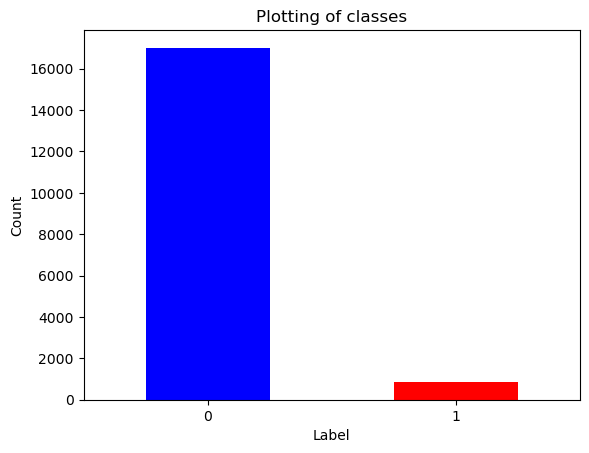

In [9]:
counts = data['fraudulent'].value_counts()
counts.plot(kind='bar', color=['blue', 'red'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Plotting of classes')
plt.xticks(rotation=0)
plt.show() #check the weight of each class.

In [10]:
max_len = 250 # established length from where the sentences will be padded
max_words = 100000 # number of unique words

#transforming the labels into numpy array:
labels = data['fraudulent'].values
text = data['text']

tokenizer = keras.preprocessing.text.Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True) #clean noise and lower case the text.
tokenizer.fit_on_texts(text)    # this initializes a dictionary of most common tokens
sequences = tokenizer.texts_to_sequences(text)  # convert the text into a numerical representation

word_index = tokenizer.word_index  #creates a new dictionary with both the text its index


data = pad_sequences(sequences, maxlen=max_len) #add 0s to the sequences that are bigger than the defined maximum lenght.

print('\nShape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# shuffle the data
indices = np.arange(data.shape[0])  # creates a new array called indices that contains the row indices of the data array.
np.random.shuffle(indices) # shuffle the arrays order
data = data[indices]  # reorder rows of array on the indices of the shuffled array
labels = labels[indices]  # reorder rows of array on the indices of the shuffled array


Shape of data tensor: (17880, 250)
Shape of label tensor: (17880,)


## Model 1

Now that we have our text and labels ready to create and train a model, we create our first model, "Model 1". In order to train and test it we make use of the train_test_split function of the sklearn library, which already does the splitting of our data for us into train and test and we'll also want a validation set to keep a better track of our model's learning.
After we split the data into these smaller sets, we print their shapes to confirm if they make sense.
Afterwards, we create a random seed so that, everytime we run the code, the results will be the same. And then, we define our model. This part is where we decide which type of architecture our model will have:
- we decide on setting the output dimensions to 20 for our "Embbeding" layer.The output dimension of the Embedding layer determines the size of the learned embeddings for each word in the input text.
- the model is of type "sequential" (stack of layers where the output of one layer is passed as the input to the next layer) with three layers: an Embbeding layer, a Bidirectional layer (allows the layer to process the input sequence in both forward and backward directions), LSTM layer with 20 hidden units, and a Dense layer (applies a linear transformation to the input and outputs a scalar value) with 1 neuron (size of the output space, which is the one used for binary classification) with an activation function "sigmoid" (takes any real value as input and outputs values in the range of 0 to 1, commonly used for binary classification tasks).

After we define the model we compile it. At this stage we define its loss function, optimizer and the evaluation metrics to use during its training. In this case, we are using "binary crossentropy" as the loss function (since this is a binary classification problem), the "adam" optimizer (a stochastic gradient descent (SGD) optimization algorithm), and "accuracy" as the evaluation metric.

Next, we fit the model with our train sets and also our validation sets, to keep track of our validation loss and validation accuracy. We set the number of epochs to 10 and a batch size of 64 (the model will process 64 training examples at a time) which is considered a large batch size (compared to 32) to speed up the learning process. 

Afterwards, we report the evaluation of the test data, we plot the learning rate, get the confusion matrix and its classification report, which is what will tell us if the model learned or not and how well it learned.

In [11]:
# splitting with sklearn library
# inspiration for code https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
y = labels # fraudulent or not 
X = data # job add

# split into train and test: 
#we set a seed so that the same splitting is obtained avery time the code is run.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)
# create the validation portion:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [12]:
#Check the dimensions of our train and test sets for both data and labels.
print("X_train shape: ",X_train.shape)
print("X_test shape : ",X_test.shape)

print("y_train shape: ",y_train.shape)
print("y_test shape : ",y_test.shape)

X_train shape:  (11443, 250)
X_test shape :  (3576, 250)
y_train shape:  (11443,)
y_test shape :  (3576,)


In [13]:
np.random.seed(111) #set a random seed 

#define the model 
output_dim=20
model1=Sequential(name = "model1")
model1.add(Embedding(max_words,output_dim,input_length=max_len))
model1.add(Bidirectional(LSTM(20 )))
model1.add(Dense(1,activation='sigmoid'))

model1.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

print(model1.summary())

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 20)           2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 40)               6560      
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 2,006,601
Trainable params: 2,006,601
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
# fit the model and observe the learning process with its respective metrics
history1 = model1.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val, y_val)) 

Epoch 1/10
179/179 [==============================] - 45s 179ms/step - loss: 0.2527 - accuracy: 0.9461 - val_loss: 0.1713 - val_accuracy: 0.9532
Epoch 2/10
179/179 [==============================] - 24s 132ms/step - loss: 0.1252 - accuracy: 0.9583 - val_loss: 0.1011 - val_accuracy: 0.9710
Epoch 3/10
179/179 [==============================] - 17s 94ms/step - loss: 0.0656 - accuracy: 0.9814 - val_loss: 0.0855 - val_accuracy: 0.9727
Epoch 4/10
179/179 [==============================] - 16s 89ms/step - loss: 0.0312 - accuracy: 0.9924 - val_loss: 0.0804 - val_accuracy: 0.9769
Epoch 5/10
179/179 [==============================] - 12s 66ms/step - loss: 0.0148 - accuracy: 0.9970 - val_loss: 0.0878 - val_accuracy: 0.9804
Epoch 6/10
179/179 [==============================] - 9s 50ms/step - loss: 0.0101 - accuracy: 0.9982 - val_loss: 0.1014 - val_accuracy: 0.9787
Epoch 7/10
179/179 [==============================] - 9s 52ms/step - loss: 0.0068 - accuracy: 0.9990 - val_loss: 0.0943 - val_accuracy:

In [15]:
history1.history

{'loss': [0.2527052164077759,
  0.12517230212688446,
  0.06555432826280594,
  0.031228182837367058,
  0.01477857120335102,
  0.01012476347386837,
  0.006808331701904535,
  0.004529453348368406,
  0.0037683704867959023,
  0.0018803211860358715],
 'accuracy': [0.9460805654525757,
  0.9583151340484619,
  0.9813860058784485,
  0.9923970699310303,
  0.9970287680625916,
  0.9981648325920105,
  0.9989513158798218,
  0.9992135167121887,
  0.9992135167121887,
  0.9998252391815186],
 'val_loss': [0.17134413123130798,
  0.10107768326997757,
  0.08547592163085938,
  0.0803947001695633,
  0.08778192847967148,
  0.10136708617210388,
  0.09429822117090225,
  0.10105157643556595,
  0.10843738913536072,
  0.11369042843580246],
 'val_accuracy': [0.953163206577301,
  0.9709891676902771,
  0.9727367758750916,
  0.9769311547279358,
  0.9804264307022095,
  0.9786787629127502,
  0.9783292412757874,
  0.9786787629127502,
  0.9793778657913208,
  0.9797273874282837]}

In [16]:
#evaluate on the test data:
print('Evaluate on the test data:')
results = model1.evaluate(X_test, y_test)

Evaluate on the test data:
112/112 [==============================] - 1s 8ms/step - loss: 0.0927 - accuracy: 0.9824


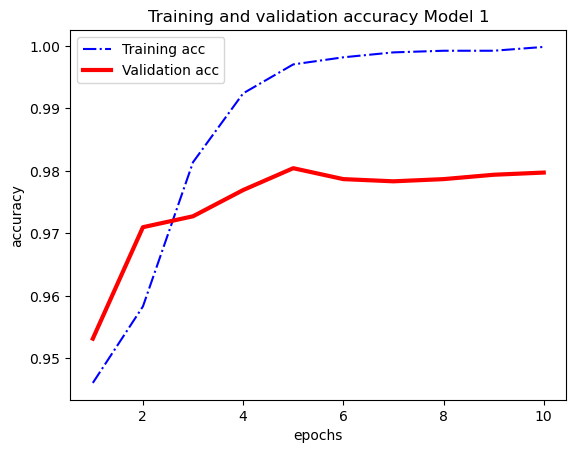

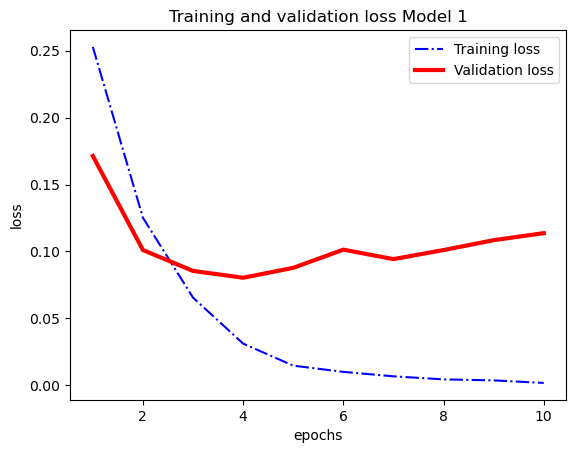

In [17]:
#Plot the results from above to understand the learning process more clearly over each epoch.

import matplotlib.pyplot as plt

loss = history1.history['loss']
val_loss = history1.history['val_loss']
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

epochs = range(1, len(loss) + 1)  # to count from epoch 1 to epoch 3

plt.plot(epochs, acc, 'b', linestyle = 'dashdot', label='Training acc')
plt.plot(epochs, val_acc, 'r', linewidth = '3', label='Validation acc')
plt.title('Training and validation accuracy Model 1')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', linestyle = 'dashdot', label='Training loss')
plt.plot(epochs, val_loss, 'r', linewidth = '3', label='Validation loss')
plt.title('Training and validation loss Model 1')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.show()

In [18]:
y_pred = model1.predict(X_test)
y_pred = np.around(y_pred, decimals=0)
y_pred

112/112 [==============================] - 1s 7ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [19]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat) #confusion matrix: useful summary of the model´s preformance.

[[3407   16]
 [  47  106]]


In [20]:
clas_rep = classification_report(y_test, y_pred, target_names=['0', '1'])
print(clas_rep) #Check the evaluation metrics.

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3423
           1       0.87      0.69      0.77       153

    accuracy                           0.98      3576
   macro avg       0.93      0.84      0.88      3576
weighted avg       0.98      0.98      0.98      3576



### Model 1 - Observations

With the evaluation on the test data one can conclude that, with an accuracy of 0.97 and a loss of 0.15, the model performed very well on the unseen data. But, to really know how good these results are, we decided to plot the learning progress over the epochs, print its confusion matrix and its classification report.
- When it comes to the plot, the model shows that, until the second epoch, it was learning well, but, after that point, it started overfitting.
- The confusion matrix shows that the model predicted 3484 samples correctly out of a total of 3576 samples. In other words, it correctly predicted 3369 true negatives and 115 true positives. However, it also misclassified 19 negative samples as positive (false positives) and 73 positive samples as negative (false negatives). Since the number of false negatives is relatively high, the model is most probably missing some fraudulent examples. 
- The classification report shows that the model has a high accuracy of 0.97, which means that it classified most of the examples correctly. But, the precision is 0.86 and the recall is 0.61 which indicates that the model, once again, has some problems when it comes to correctly identifying positive examples (i.e., fraud cases) and also identifies some false positives (i.e., non-fraud cases incorrectly classified as fraud). However, the F1-score (harmonic mean of precision and recall) of 0.71 could be a good trade-off between precision and recall.

## Model 2

Now we'll move on to our next model, "Model 2". 
When it comes to the splitting of the data into training, test and validation sets we did the same as for "Model 1".
Afterwards, we create again the same random seed so that the results can be reproducible. And then, we define our model:
- once again we set the output dimensions to 20 for our "Embbeding" layer.
- the model is, once more, of type "Sequential" with four layers: an Embbeding layer, a Bidirectional LSTM layer with, this time, 30 hidden units, a Dense layer with 24 neuron units with the activation function "relu" (transforms negative values to 0 of the outputs of our 24 units, and keeps the positive values as they are), and another Dense layer with 1 neuron with the activation function "sigmoid". 

After we define the model we compile it. Once again, we are using "binary crossentropy" as the loss function, the "adam" optimizer, and "accuracy" as the evaluation metric.

Next, we fit the model with our train sets and also our validation sets. We set the number of epochs to 10 and a batch size of 64. 

Afterwards, we report the evaluation of the test data, we plot the learning rate, get the confusion matrix and its classification report, which is what will tell us if the model learned or not and how well it learned.

In [21]:
# splitting with sklearn library
# inspiration for code https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
y = labels # fraudulent or not 
X = data # job add

# split into train and test: 
#we set a seed so that the same splitting is obtained every time the code is run.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)
# create the validation portion:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [22]:
np.random.seed(111)

#define the model

output_dim=20
model2=Sequential(name = "model2")
model2.add(Embedding(max_words,output_dim,input_length=max_len))
model2.add(Bidirectional(LSTM(30 )))
model2.add(Dense(24, activation='relu'))
model2.add(Dense(1,activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

print(model2.summary())

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 20)           2000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 60)               12240     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 24)                1464      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 2,013,729
Trainable params: 2,013,729
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# fit the model and observe the learning process with its respective metrics
history2 = model2.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/10
179/179 [==============================] - 28s 126ms/step - loss: 0.2411 - accuracy: 0.9461 - val_loss: 0.1328 - val_accuracy: 0.9574
Epoch 2/10
179/179 [==============================] - 17s 97ms/step - loss: 0.0894 - accuracy: 0.9722 - val_loss: 0.0873 - val_accuracy: 0.9745
Epoch 3/10
179/179 [==============================] - 13s 70ms/step - loss: 0.0393 - accuracy: 0.9879 - val_loss: 0.0832 - val_accuracy: 0.9769
Epoch 4/10
179/179 [==============================] - 11s 60ms/step - loss: 0.0138 - accuracy: 0.9964 - val_loss: 0.1034 - val_accuracy: 0.9759
Epoch 5/10
179/179 [==============================] - 9s 53ms/step - loss: 0.0088 - accuracy: 0.9978 - val_loss: 0.1239 - val_accuracy: 0.9650
Epoch 6/10
179/179 [==============================] - 8s 43ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.1257 - val_accuracy: 0.9766
Epoch 7/10
179/179 [==============================] - 7s 40ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.1275 - val_accuracy: 0

In [24]:
print('Evaluate on the test data:')
results = model2.evaluate(X_test, y_test)

Evaluate on the test data:
112/112 [==============================] - 1s 9ms/step - loss: 0.1182 - accuracy: 0.9790


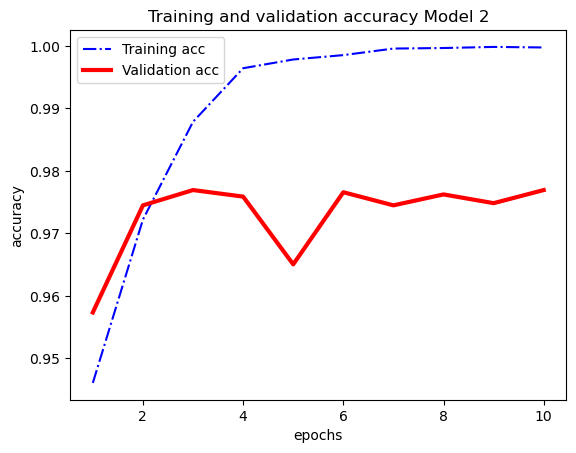

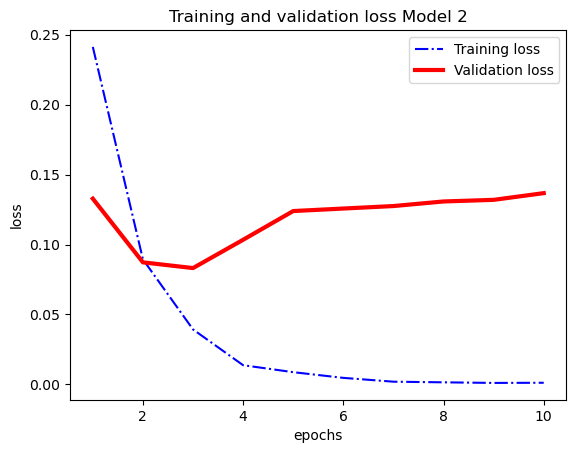

In [25]:
#Plot the results from above to understand the learning process more clearly over each epoch.

import matplotlib.pyplot as plt

loss = history2.history['loss']
val_loss = history2.history['val_loss']
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

epochs = range(1, len(loss) + 1)  # to count from epoch 1 to epoch 3

plt.plot(epochs, acc, 'b', linestyle = 'dashdot', label='Training acc')
plt.plot(epochs, val_acc, 'r', linewidth = '3', label='Validation acc')
plt.title('Training and validation accuracy Model 2')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', linestyle = 'dashdot', label='Training loss')
plt.plot(epochs, val_loss, 'r', linewidth = '3', label='Validation loss')
plt.title('Training and validation loss Model 2')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.show()

In [26]:
import sys
sys.path.append(" /export/home/iara.martins-da-costa-sobreiro/.local/lib/python3.10/site-packages")

In [27]:
#Check the model actual predictions:
y_pred = model2.predict(X_test)
y_pred = np.around(y_pred, decimals=0)
y_pred

112/112 [==============================] - 1s 7ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [28]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat) #confusion matrix: useful summary of the model´s preformance.

[[3389   34]
 [  41  112]]


In [29]:
clas_rep = classification_report(y_test, y_pred, target_names=['0', '1'])
print(clas_rep) #Check the evaluation metrics.

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3423
           1       0.77      0.73      0.75       153

    accuracy                           0.98      3576
   macro avg       0.88      0.86      0.87      3576
weighted avg       0.98      0.98      0.98      3576



### Model 2 - Observations

With the evaluation on the test data one can conclude that, with an accuracy of 0.98 and a loss of 0.14, this model also performed very well on the unseen data. 
- When it comes to the plot, the model shows that, until the 4th epoch, it was learning well, but, after that point, it started overfitting.
- The confusion matrix shows that the model predicted the negative class (0) correctly for 3356 samples, but incorrectly predicted it as positive for 32 samples. On the other hand, the model correctly predicted the positive class (1) for 131 samples, but incorrectly predicted it as negative for 57 samples. The model is identifying the negative samples better than the positive ones.
- Based on the metrics, the model has a high accuracy of 0.98, which means it classified the majority of the samples correctly. However, the model has a relatively low precision of 0.80, which means that it incorrectly classified some negative samples as positive. The recall of 0.70 is also relatively low, because it shows that the model failed to correctly identify some positive samples. The F1-score is also lower at 0.75 for the positive class, which, once again, shows that the model is not performing well on identifying the positive class. In general, the model has a high accuracy, but its precision and recall are lower for the positive class, which is something that we have to be cautious about.

## Model 3

Now we have another model called "Model 3". 
This model has some differences compared to the previous ones but the bigger one is the data that it's fed with. As we plotted above, our classes are imbalanced, which can be a reason why the models don't identify the positive classes as good as the negative ones. So we decided to oversample our minority class (positive one) with the function "RandomOverSampler" from the imblearn library and apply it to our training data. Afterwards, we plot it to check if it worked and the barplot shows that both classes are now balanced. Then we do the same splitting as before but on the resampled data.

Afterwards, we create again the same random seed so that the results will be reproducible. And then, we define our model:
- the output dimensions are set to 50 for our "Embbeding" layer.
- the model is, once more, of type "Sequential" with three layers (similar to the 1st one): an Embbeding layer, a Bidirectional LSTM layer with 30 hidden units, and a Dense layer with 1 neuron with the activation function "sigmoid". 

After we define the model we compile it. Once more, we are using "binary crossentropy" as the loss function, the "adam" optimizer, and "accuracy" as the evaluation metric.

Next, we fit the model with our train sets and also our validation sets. We set the number of epochs to 10 and a batch size of 64. 

Afterwards, we report the evaluation of the test data, we plot the learning rate, get the confusion matrix and its classification report, which is what will tell us if the model learned or not and how well it learned.

In [30]:
#import the imblearn library for oversampling
import sys
sys.path.append('/export/home/iara.martins-da-costa-sobreiro/.local/lib/python3.10/site-packages') #acess it through path
import imblearn

In [31]:
# oversample the smaller classes
from imblearn.over_sampling import RandomOverSampler

# start oversampler
ros = RandomOverSampler(sampling_strategy='minority')

# apply the created oversampler on the training data and then return it.
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

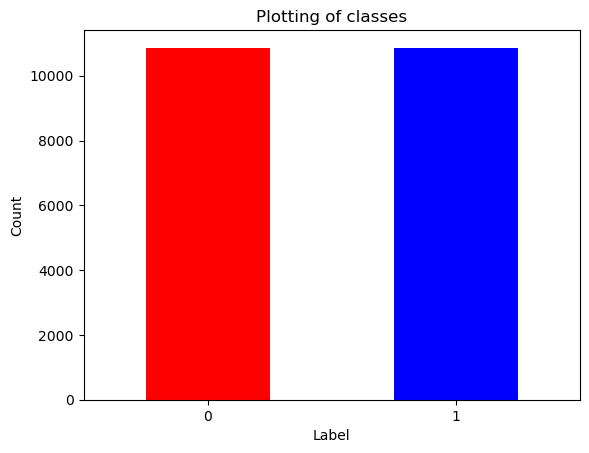

In [32]:
# Check if classes are effectively oversampled by plotting them again.

# pd.Series() to convert from array into a Pandas series so that it can be used with vales_counts()
# value_counts() returns a new Series object where the index is the unique values of the original Series, and the values are the count of each unique value.
counts = pd.Series(y_resampled).value_counts() 

# Plot these counts with a bar plot
counts.plot(kind='bar', color=['red', 'blue'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Plotting of classes')
plt.xticks(rotation=0)
plt.show()

In [33]:
# splitting with the new resampled variables
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1)

In [34]:
np.random.seed(111)

# define model: uing the same compiling as the one for first model

output_dim=50
model3=Sequential(name = "model3")
model3.add(Embedding(max_words,output_dim,input_length=max_len))
model3.add(Bidirectional(LSTM(30)))
model3.add(Dense(1,activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

In [35]:
# fit the model and observe the learning process with its respective metrics

history3 = model3.fit(X_train, y_train,
                      epochs=10,
                      batch_size=64,
                      validation_data=(X_val, y_val))

Epoch 1/10
272/272 [==============================] - 50s 168ms/step - loss: 0.1969 - accuracy: 0.9153 - val_loss: 0.0288 - val_accuracy: 0.9949
Epoch 2/10
272/272 [==============================] - 33s 121ms/step - loss: 0.0166 - accuracy: 0.9975 - val_loss: 0.0127 - val_accuracy: 0.9961
Epoch 3/10
272/272 [==============================] - 23s 84ms/step - loss: 0.0075 - accuracy: 0.9983 - val_loss: 0.0141 - val_accuracy: 0.9970
Epoch 4/10
272/272 [==============================] - 16s 59ms/step - loss: 0.0066 - accuracy: 0.9984 - val_loss: 0.0155 - val_accuracy: 0.9961
Epoch 5/10
272/272 [==============================] - 12s 45ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0123 - val_accuracy: 0.9963
Epoch 6/10
272/272 [==============================] - 12s 45ms/step - loss: 0.0043 - accuracy: 0.9986 - val_loss: 0.0120 - val_accuracy: 0.9963
Epoch 7/10
272/272 [==============================] - 8s 31ms/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.0213 - val_accuracy

In [36]:
print('Evaluate on the test data:')
results = model3.evaluate(X_test, y_test)

Evaluate on the test data:
72/72 [==============================] - 1s 8ms/step - loss: 0.0035 - accuracy: 0.9996


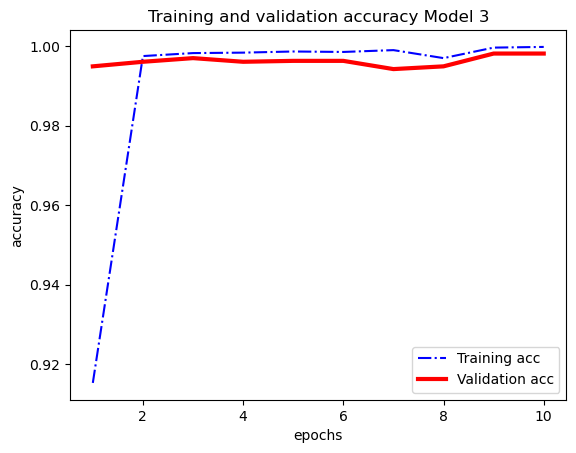

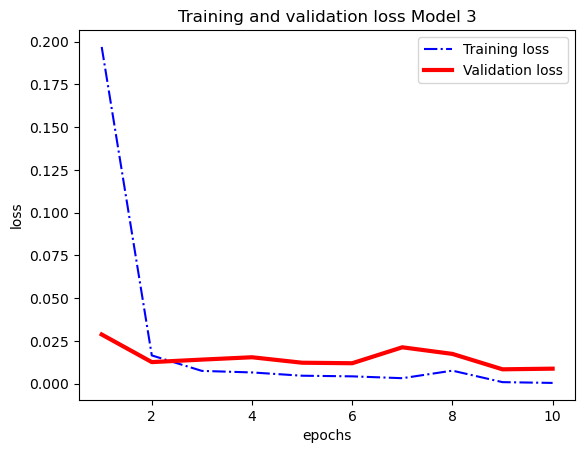

In [37]:
#Plot the results from above to understand the learning process more clearly over each epoch.

import matplotlib.pyplot as plt

loss = history3.history['loss']
val_loss = history3.history['val_loss']
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1, len(loss) + 1)  # to count from epoch 1 to epoch 3

plt.plot(epochs, acc, 'b', linestyle = 'dashdot', label='Training acc')
plt.plot(epochs, val_acc, 'r', linewidth = '3', label='Validation acc')
plt.title('Training and validation accuracy Model 3')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', linestyle = 'dashdot', label='Training loss')
plt.plot(epochs, val_loss, 'r', linewidth = '3', label='Validation loss')
plt.title('Training and validation loss Model 3')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.show()

In [38]:
#Check the model actual predictions:
y_pred = model3.predict(X_test)
y_pred = np.around(y_pred, decimals=0)
y_pred

72/72 [==============================] - 1s 7ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [39]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat) #confusion matrix: useful summary of the model´s preformance.

[[2161    1]
 [   0  127]]


In [40]:
clas_rep = classification_report(y_test, y_pred, target_names=['0', '1'])
print(clas_rep) #Check the evaluation metrics.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2162
           1       0.99      1.00      1.00       127

    accuracy                           1.00      2289
   macro avg       1.00      1.00      1.00      2289
weighted avg       1.00      1.00      1.00      2289



### Model 3 - Observations

With the evaluation on the test data one can conclude that, with an accuracy of 0.999 and a loss of 0.002, this model performed almost perfectly on the unseen data. 
- When it comes to the plot, the model shows no overfitting, on the contrary, it's showing a very good learning rate.
- The confusion matrix shows that the model shows a very good classification performance, as it commits very few errors in predicting the labels of the test data. More specifically, there were 1709 true negative (TN) predictions and 1781 true positive (TP) predictions, which shows that the model classified 3490 samples correctly. It made no false positive predictions and only 2 false negative ones. It only had 2 wrong out of 1783 positives.
- Based on the metrics, the model shows a very good performance for both classes. This is because, the precision for both is 1.00, which means that all predicted positive instances are really positive and all predicted negative instances are really negative. The recall is also, for both classes, 1.00, meaning that all the positive samples have been correctly predicted as positive and all the negative samples predicted as negative. When it comes to the F1-score, for both classes it is also 1.00.

## Model-bert

For this last model, we decided to try something different to see if our results would get better. We used BERT's embeddings to serve as input to a model that we created called "Model_bert". This model's architecture is the same as the one of the model three (even though we tried many different architectures with different layers and units to see if more complex patterns would be learned). In this case, we are doing what is called "transfer learning".  The advantages of using BERT's embeddings for this task is because BERT is pre-trained on a large corpus of text, which allows it to capture the nuances of language better than traditional embeddings.
- To do this, we have to import the BertTokenizer and BertModel from the "bert-base-uncased" model from the transformers library. Then, we set the model to "eval" mode. Next, we create a function called "embeddings" which takes a list of sentences as input and returns two types of embeddings: CLS embeddings and summed embeddings. In order to obtain these embeddings, the function first encodes the input sentences using the tokenizer, which returns the input IDs, attention masks, and token type IDs. These are then fed to the pre-trained BERT model, which returns the hidden states of all tokens from the last layer of the model. Then, we stack and squeeze the hidden states to obtain a tensor that contains the hidden states for each token in the input sequence at each layer of the neural network. We get the embeddings by taking the mean of the last four hidden states for the CLS token. The summed embeddings are obtained by summing the last four hidden states for each token and taking the mean across all tokens in the input sequence. Finally, the function returns the cls and summed embeddings as numpy arrays.
- After we get the cls emmbedings and the summed ones, we create sentence embeddings for each sentence in the 'text' column of a pandas dataframe named 'df'. The provided code loops through each sentence using the range function and calls the 'embeddings' function (previously created) to get the two types of sentence embeddings - 'cls_emb' and 'b_emb'. For each sentence, the 'cls_emb' is appended to the 'cls_embeddings' list, while the 'b_emb' is not used here and is commented out since we will only be interested in the cls emmbeddings. This is because the CLS token is the first token in a BERT input and is specifically trained to contain the entire sequence representation for classification tasks, so it can be used to get a single vector representation for a sentence.
- After we get the cls embeddings we shuffle them and then we do the same splitting process as it was previously done for the other models.
- Then, I use the same architecture as it was used for model three. I decided on this one after trying different ones with more layers and hidden units but the results didn't seem to get better.
- The type of compiling is the same as the previous ones. The fitting is very similar with the only difference being the number of epochs that are set to 8 instead of 10 since it didn't show improvement and takes less time to train.

In [41]:
import torch
from transformers import BertTokenizer, BertModel
#check if GPU is available
if torch.cuda.is_available():   
    device = torch.device("cuda:1") #set device to utilize the power of the indexed GPU to perform computations.
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu") #use CPU if no GPU available

There are 2 GPU(s) available.
Device name: Tesla T4


In [42]:
# import tokenizer from the BERT base uncased model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# import the pre-train model from BERT base uncased
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, #return all hidden-states
                                  ).to(device)

# set the model in eval mode for fine-tunning
model.eval()


# get BERT embeddings for the words of all the dataset sentences
def embeddings(sentences):
    #encode_plus()returns the actual input ids, the attention masks, and the token type ids, and it returns all of these in a dictionary.
    encoding = tokenizer.encode_plus(sentences, 
                                     add_special_tokens = True, 
                                     truncation=True,
                                     max_length = max_len,
                                     padding=True,
                                     return_attention_mask= True, 
                                     return_tensors="pt") 

    tokens_tensor = encoding["input_ids"] 
    segments_tensors = encoding["attention_mask"] 
    segments_ids = encoding["token_type_ids"]
    
    with torch.no_grad():
                          
        outputs = model(tokens_tensor.to(device), segments_tensors.to(device)) # feed the input to the model.
    #tokens_tensor: tensor where it contains the sentences input ID's from the encoding dictionary
    #segment_tensors:attention masks
    
    hidden_states = outputs[2] #stores the hidden states of the tokens from the last layer of the BERT model in the hidden_states variable. 

    
    del outputs #delete the outputs from memory
    
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1) 
    token_embeddings = token_embeddings.permute(1,0,2) 
    #the resulting token_embeddings tensor contains the hidden states for each token in the input sequence at each layer of the neural network
    
    cls_emb = token_embeddings[0][-4:].mean(dim=0).detach().cpu().numpy() #Get the CLS embbedings

    sent_token_vecs_sum = []

    for token in token_embeddings:
        tok = token.to("cpu")  
        token.detach() 
        del token  #reduce memory footprint

        # Sum the last four layers
        sum_vec = torch.sum(tok[-4:], dim=0)
        sent_token_vecs_sum.append(sum_vec)

    b_emb = torch.stack(sent_token_vecs_sum, dim=0).mean(dim=0).detach().cpu().numpy() #Get the summed embbedings
    #summed embeddings of each token in the input sequence.    
    return cls_emb, b_emb

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
from tqdm import tqdm #display progress bar
cls_embeddings = []
summed_embeddings = []

for idx in tqdm(range(0, len(df['text'])), desc ="Creating sentence embeddings"):
    cls_emb, b_emb = embeddings(df['text'][idx]) #call the emmbedings function to get the two types of sentence emmbeddings
    #summed_embeddings.append(b_emb) #append the embeddings to the list
    cls_embeddings.append(cls_emb) #append the embeddings to the list

Creating sentence embeddings: 100%|██████████| 17880/17880 [14:50<00:00, 20.08it/s]


In [44]:
#Shuffle the embeddings
indices = np.arange(np.array(cls_embeddings).shape[0])
np.random.shuffle(indices) #shuffle the indexes randomly
cls_emb = np.array(cls_embeddings) #convert into NumPy arrays

cls_emb = cls_emb[indices] # shuffle array

In [45]:
y = labels # fraudulent or not 
X = cls_emb # job add

# split into train and test: 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)
#we set a seed so that the same splitting is obtained avery time the code is run.
# create the validation portion:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [46]:
np.random.seed(111)

#define the model: based on the third model.
output_dim= 50 
model_bert=Sequential(name = "model_bert")
model_bert.add(Embedding(max_words,output_dim,input_shape = (768,))) 
model_bert.add(Bidirectional(LSTM(30)))
model_bert.add(Dense(1, activation='sigmoid'))

model_bert.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
print(model_bert.summary())

Model: "model_bert"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 768, 50)           5000000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 60)               19440     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 61        
                                                                 
Total params: 5,019,501
Trainable params: 5,019,501
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
X_test.shape

(3576, 768)

In [48]:
history_bert = model_bert.fit(X_train, y_train,
                    epochs=8,
                    batch_size=64,
                    validation_data = (X_val, y_val))

Epoch 1/8
179/179 [==============================] - 15s 59ms/step - loss: 0.2435 - accuracy: 0.9443 - val_loss: 0.1891 - val_accuracy: 0.9532
Epoch 2/8
179/179 [==============================] - 9s 52ms/step - loss: 0.2007 - accuracy: 0.9494 - val_loss: 0.1895 - val_accuracy: 0.9532
Epoch 3/8
179/179 [==============================] - 8s 47ms/step - loss: 0.2008 - accuracy: 0.9494 - val_loss: 0.1892 - val_accuracy: 0.9532
Epoch 4/8
179/179 [==============================] - 9s 49ms/step - loss: 0.2010 - accuracy: 0.9494 - val_loss: 0.1891 - val_accuracy: 0.9532
Epoch 5/8
179/179 [==============================] - 9s 52ms/step - loss: 0.2007 - accuracy: 0.9494 - val_loss: 0.1908 - val_accuracy: 0.9532
Epoch 6/8
179/179 [==============================] - 9s 49ms/step - loss: 0.2008 - accuracy: 0.9494 - val_loss: 0.1892 - val_accuracy: 0.9532
Epoch 7/8
179/179 [==============================] - 9s 49ms/step - loss: 0.2006 - accuracy: 0.9494 - val_loss: 0.1891 - val_accuracy: 0.9532
Epoch

In [52]:
print('Evaluate on the test data:')
results = model_bert.evaluate(X_test, y_test)

Evaluate on the test data:
112/112 [==============================] - 3s 23ms/step - loss: 0.1770 - accuracy: 0.9572


In [50]:
y_pred = (model_bert.predict(X_test)).astype("int32")
print(confusion_matrix(y_pred, y_test))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

112/112 [==============================] - 3s 18ms/step
[[3423  153]
 [   0    0]]
0.9572147651006712
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3423
           1       0.00      0.00      0.00       153

    accuracy                           0.96      3576
   macro avg       0.48      0.50      0.49      3576
weighted avg       0.92      0.96      0.94      3576



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


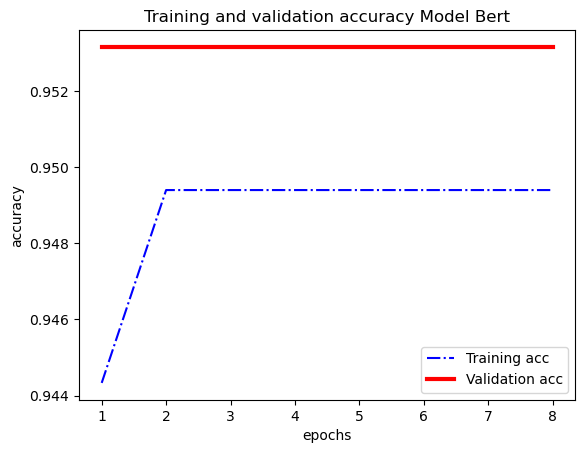

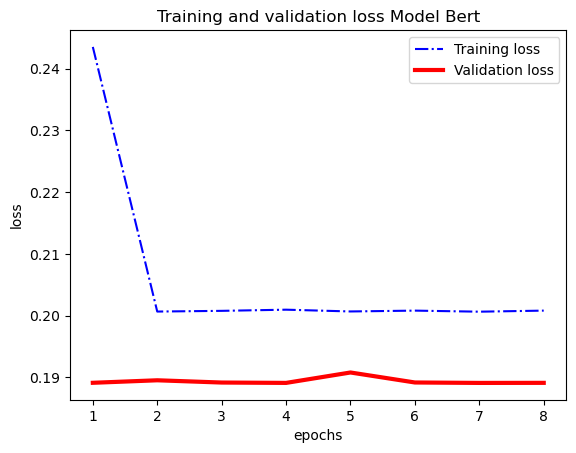

In [51]:
# Plot the results:

#Plot the results from above to understand the learning process more clearly over each epoch.

import matplotlib.pyplot as plt

loss = history_bert.history['loss']
val_loss = history_bert.history['val_loss']
acc = history_bert.history['accuracy']
val_acc = history_bert.history['val_accuracy']

epochs = range(1, len(loss) + 1)  # to count from epoch 1 to epoch 3

plt.plot(epochs, acc, 'b', linestyle = 'dashdot', label='Training acc')
plt.plot(epochs, val_acc, 'r', linewidth = '3', label='Validation acc')
plt.title('Training and validation accuracy Model Bert')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', linestyle = 'dashdot', label='Training loss')
plt.plot(epochs, val_loss, 'r', linewidth = '3', label='Validation loss')
plt.title('Training and validation loss Model Bert')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.show()

### Model_bert - Observations

Only based on the evaluation on the test data, one can conclude that, with an accurancy of 0.96 and a loss of 0.18, this model performed well on the unseen data. 
- When it comes to the plot, the model shows a stable validation loss and validation accuracy across all the epochs, but since the accuracy is quite high, this shows that the model is performing well on the given dataset.
- The confusion matrix and classification report show that the model is predicting all instances as the majority class (0). This is because all the metrics (precision, recall and f-1 score) are zero for class 1. All this means that the model didn't predict any positive instances correctly and all actual positive instances are being classified as negative. This is happening, most probably, because the dataset is imbalanced, with one class having significantly more instances than the other. The model is learning to predict the majority class to achieve a high overall accuracy. To deal with this issue, we tried three things:
 - do the same as we did for model three by oversampling the minority class (1).
 - manipulate the minority class' weights to serve as some form of attention marker for the model to focus on that specific class.
 - change the model architecture by adding some extra layers and their units so that it could learn more complex patterns in order to become more robust.
 
 All these measures didn't work out in end, so that's why we just sticked with this architecture.

## Conclusion

Our aim with this project was to find the best model to deal with the job fraud classification task by trying different approaches and also comparing their performances.

So, we built four different models on which we applied different measures to ensure their differences. First, we changed the architectures regarding their layers (difference between the first and the second one) which resulted in a slightly better preformance.
Then, for the third model, we applied a different measure, which is data manipulation. We also changed the output dimension to 50 and the LSTM units to 30, since they also contributed a bit to the performance. Our first two models trained on imbalanced data, which can be a problem for models to deal with  when it comes to correctly classify the existing classes. So, we decided to oversample our minority class (1) in order to make the data balanced. In the end, we boosted our model's performance a lot as it can be confirmed by its results, where both classes were identified correctly. This measure placed our third model in the first place spot.

Afterwards, we decided to create a fourth model, which has the same architecture as our best model so far (3rd) but, this time, we used BERT's embeddings as input to see if we could boost the performance of the model even more. After we did this, our model, contrary to the previous ones, showed that it couldn't correctly classify our minority class at all. So, to deal with this, as it was mentioned before, we tried different approaches like, per example, the one of model 3 (since it was our best model so far) and, even then, nothing changed. So, we decided to leave it as it is now.

So, after all the experimenting, we concluded, once again, that the best model was the third model, since it was the one that had the best results and identified all our classes perfectly. However, one must not forget that this model's results were generated using oversampled data, so the true performance of this classifier on a real-world dataset might not be as high. This means that, if the sole purpose is just to reach the highest accuracy possible, the third model is the best, but if we want to stick to real results without manipulating the data, we conclude that our second model is better.

Another thing that we want to note is that, if we switch the splitting process, so validation first and then training, we boost all our models' performances (this is a technique used to boost models' results) but, since our goal was to compare them, we decided to stick to the other order (since it is considered the most common when one wants to compare models' performances).